<a href="https://colab.research.google.com/github/alexbarbosa1525/Lighthouse---Previs-o-de-Falhas/blob/main/Indicium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Desafio Cientista de Dados


Introdução

	Olá candidato, o objetivo deste desafio é testar os seus conhecimentos sobre a resolução de problemas de análise de dados e aplicação de modelos preditivos. Queremos testar seus conhecimentos dos conceitos estatísticos de modelos preditivos, criatividade na resolução de problemas e aplicação de modelos básicos de machine learning.  É importante deixar claro que não existe resposta certa e que o que nos interessa é sua capacidade de descrever e justificar os passos utilizados na resolução do problema. 

Desafio

  `Seu objetivo é identificar quais máquinas apresentam potencial de falha tendo como base dados extraídos através de sensores durante o processo de manufatura.  Para isso são fornecidos dois datasets: um dataset chamado desafio_manutencao_preditiva_treino composto por 6667 linhas, 9 colunas de informação (features) e a variável a ser prevista (“failure_type”). `

`O segundo dataset chamado de desafio_manutencao_preditiva_teste possui 3333 linhas e 8 colunas e não possui a coluna “failure_type”. Seu objetivo é prever essa coluna a partir dos dados enviados e nos enviar para avaliação dos resultados.`

Entregas

Descreva graficamente os dados disponíveis, apresentando as principais estatísticas descritivas. 

Comente o porquê da escolha dessas estatísticas.

Explique como você faria a previsão do tipo de falha a partir dos dados.

Quais variáveis e/ou suas transformações você utilizou e por quê?

Qual tipo de problema estamos resolvendo (regressão, classificação)? 

Qual modelo melhor se aproxima dos dados e quais seus prós e contras? 

Qual medida de performance do modelo foi escolhida e por quê?

Envie o resultado final do modelo em uma planilha com apenas duas colunas (rowNumber, predictedValues). 

A entrega deve ser feita através de um repositório de código público que contenha:
- README explicando como rodar o projeto
- Arquivo requirements com todos os pacotes utilizados
- Relatório de EDA em PDF, Jupyter Notebook ou semelhante conforme passo 1
- Códigos de modelagem utilizados no passo 2.
- Arquivo final predicted.csv conforme passo 3 acima.



The dataset consists of 10 000 data points stored as rows with 8 features in columns:

- UID: unique identifier ranging from 1 to 10000
- product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
- type: just the product type L, M or H from column 2
- air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
- process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
- rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise
- torque [Nm]: torque values are normally distributed around 40 Nm with a SD = 10 Nm and no negative values.
- tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.

- A 'machine failure' label that indicates whether the machine has failed in this particular datapoint for any of the following failure modes is true.

The machine failure consists of five independent failure modes:
- tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
- heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm. This is the case for 115 data points.
- power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
- overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.
- random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.

- tool wear failure (TWF) = 

# 0.0. IMPORTS

In [ ]:
!pip install inflection
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
import os
drive.mount("/content/drive")
# os.listdir()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import inflection
import plotly.express as px

from sklearn.model_selection  import train_test_split
from sklearn.preprocessing    import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.neighbors        import KNeighborsClassifier
from sklearn.tree             import DecisionTreeClassifier
from sklearn.naive_bayes      import GaussianNB
from sklearn.ensemble         import RandomForestClassifier
from sklearn.ensemble         import GradientBoostingClassifier
from xgboost                  import XGBClassifier

from sklearn.metrics          import mean_absolute_error, mean_squared_error
from sklearn.metrics          import f1_score
from sklearn.metrics          import cohen_kappa_score
from sklearn.metrics          import recall_score
from sklearn.metrics          import matthews_corrcoef
from sklearn.metrics          import balanced_accuracy_score
from sklearn                  import metrics            as m
from scikitplot               import metrics            as mt

from IPython.display          import Image
from IPython.core.display     import HTML

warnings.filterwarnings( 'ignore' )

## 0.1. Helper Functions

In [ ]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()


jupyter_settings()

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

#Função para calcular erro
def ml_error( model_name, y, yhat ):
  cohen_score = cohen_kappa_score(y_val, yhat)
  f1 = f1_score(y, yhat)
  recall = recall_score(y_val, yhat_knn)
  mape = mean_absolute_percentage_error( y, yhat )
  mcc = matthews_corrcoef(y, yhat)
  b_accuracy = balanced_accuracy_score(y, yhat)
    
  return pd.DataFrame( { 'Model Name': model_name,
                           'Cohen Score': cohen_score,
                           'F1 Score': f1, 
                           'Recall Score': recall,
                           'MCC': mcc,
                            'Balanced Accuracy': b_accuracy }, index=[0] )



Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Remove a exibição de notação científica
pd.set_option('float_format', '{:.2f}'.format)

## 0.2. Loading data

In [ ]:
df_teste = pd.read_csv('../content/drive/MyDrive/desafio_manutencao_preditiva_teste.csv', low_memory=False )
df_raw = pd.read_csv( '../content/drive/MyDrive/desafio_manutencao_preditiva_treino.csv', low_memory=False )



In [ ]:
df_raw.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1,M14860,M,298.10,308.60,1551,42.80,0,No Failure
1,2,L47181,L,298.20,308.70,1408,46.30,3,No Failure
2,5,L47184,L,298.20,308.70,1408,40.00,9,No Failure
3,6,M14865,M,298.10,308.60,1425,41.90,11,No Failure
4,7,L47186,L,298.10,308.60,1558,42.40,14,No Failure


# Descrição dos dados

## 1.2. Data Dimensions

In [ ]:
print( 'Number of Rows: {}'.format( df_raw.shape[0] ) )
print( 'Number of Cols: {}'.format( df_raw.shape[1] ) )

Number of Rows: 6667
Number of Cols: 9


## 1.3. Data Types

In [ ]:
df_raw.dtypes

udi                        int64
product_id                object
type                      object
air_temperature_k        float64
process_temperature_k    float64
rotational_speed_rpm       int64
torque_nm                float64
tool_wear_min              int64
failure_type              object
dtype: object

## 1.4. Check NA

In [ ]:
df_raw.isna().sum()

udi                      0
product_id               0
type                     0
air_temperature_k        0
process_temperature_k    0
rotational_speed_rpm     0
torque_nm                0
tool_wear_min            0
failure_type             0
dtype: int64

## 1.6. Change Data Types

In [ ]:
print (df_raw['failure_type'].unique())

['No Failure' 'Power Failure' 'Tool Wear Failure' 'Overstrain Failure'
 'Random Failures' 'Heat Dissipation Failure']


## 1.7. Descriptive Statistics

In [ ]:
num_attributes = df_raw.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df_raw.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Atributes

In [ ]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,udi,1.00,10000.00,9999.00,4994.59,4983.00,2895.91,0.00,-1.21
1,air_temperature_k,295.30,304.50,9.20,299.99,300.00,1.99,0.13,-0.82
2,process_temperature_k,305.70,313.80,8.10,309.99,310.00,1.49,0.02,-0.51
3,rotational_speed_rpm,1168.00,2886.00,1718.00,1537.42,1503.00,177.17,1.95,7.31
4,torque_nm,3.80,76.60,72.80,40.06,40.20,9.95,0.01,0.01
5,tool_wear_min,0.00,251.00,251.00,108.10,108.00,63.36,0.02,-1.16


### 1.7.2. Categorical Atributes

In [ ]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

product_id      6667
type               3
failure_type       6
dtype: int64

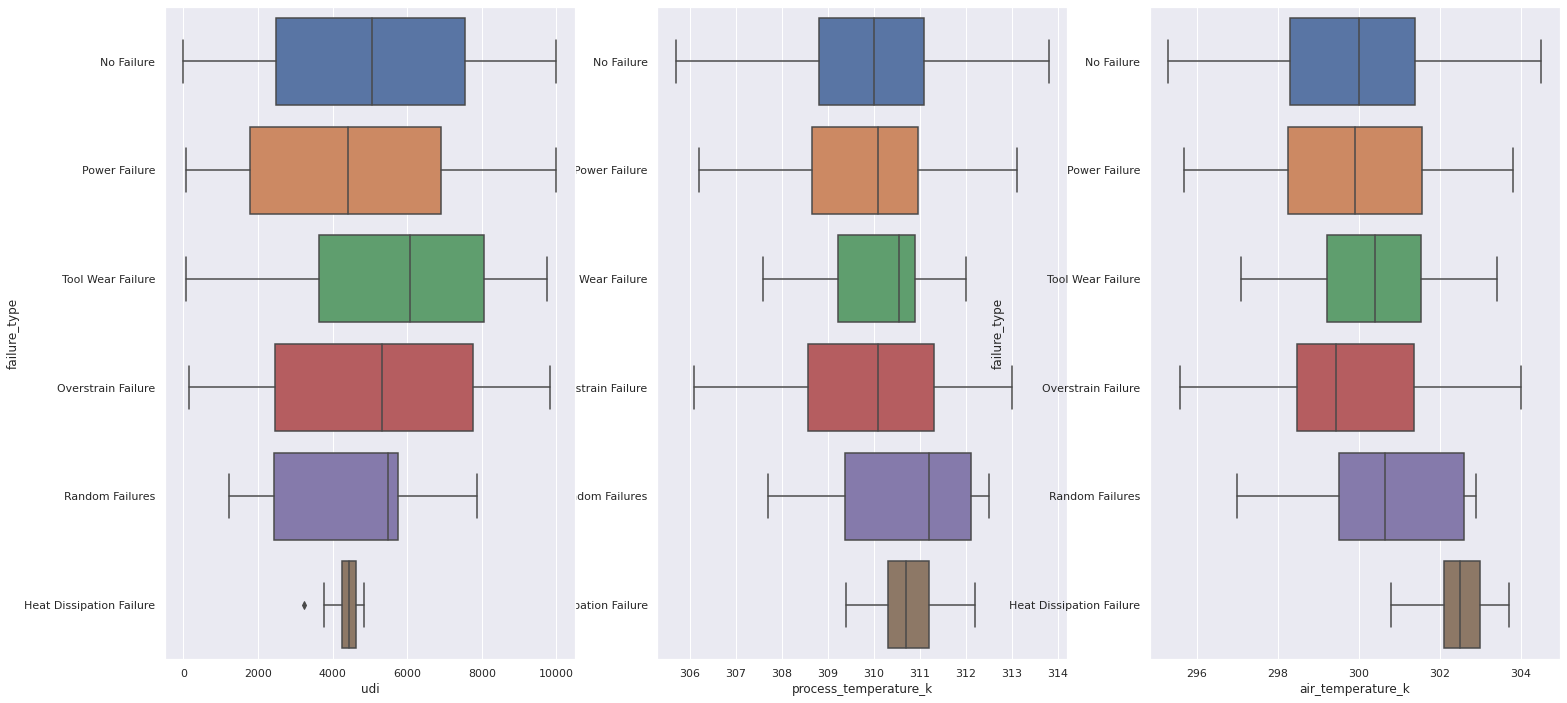

In [ ]:
#aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
aux = df_raw

plt.subplot( 1, 3, 2 )
sns.boxplot( x='process_temperature_k', y='failure_type', data=aux )

plt.subplot( 1, 3, 1 )
sns.boxplot( x='udi', y='failure_type', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='air_temperature_k', y='failure_type', data=aux )

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [ ]:
df2 = df_raw.copy()

## 2.1. Mapa Mental de Hipoteses

## 2.4. Feature Engineering

1. Vamos criar uma coluna binária de falha, para facilitar a previsão caso simplifiquemos o modelo e para testar novas features



In [ ]:
for i in range ( len (df2) ):
  if ((df2.loc[i, 'failure_type'] == 'No Failure')):
    df2.loc[i, 'failure'] = int( 0 )
  else:
    df2.loc[i, 'failure'] = int( 1 )


NameError: ignored

In [ ]:
df2.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,failure
0,1,M14860,M,298.10,308.60,1551,42.80,0,No Failure,0.00
1,2,L47181,L,298.20,308.70,1408,46.30,3,No Failure,0.00
2,5,L47184,L,298.20,308.70,1408,40.00,9,No Failure,0.00
3,6,M14865,M,298.10,308.60,1425,41.90,11,No Failure,0.00
4,7,L47186,L,298.10,308.60,1558,42.40,14,No Failure,0.00


2. Criar colunas de cada falha especifica, conforme descrito no dicionário de dados

- tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).

In [ ]:
for i in range (len (df2)):
  if df2.loc[i, 'type'] == 'H':
    df2.loc[i, 'TWF'] = df2.loc[i, 'tool_wear_min'] - int(5)

  elif df2.loc[i, 'type'] == 'M':
    df2.loc[i, 'TWF'] = df2.loc[i, 'tool_wear_min'] - int(3)

  else:
    df2.loc[i, 'TWF'] = df2.loc[i, 'tool_wear_min'] - int(2)


- heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm. This is the case for 115 data points.

In [ ]:
df2['heat_dissipation'] = df2['process_temperature_k'] - df2['air_temperature_k']


- power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.

In [ ]:
# Convertendo rotational speed de rpm para rad / s
df2['rotational_speed_rad'] = df2['rotational_speed_rpm'] / 9.549
df2['power_applied'] = df2['torque_nm']*df2['rotational_speed_rad']


In [ ]:
for i in range(len(df2)):
  if (df2.loc[i, 'power_applied'] > 9000) or (df2.loc[i, 'power_applied'] < 3500):
    df2.loc[i, 'PWF'] = 1
  else:
    df2.loc[i, 'PWF'] = 0    


- overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.

In [ ]:
df2['overstrain'] = df2['tool_wear_min'] * df2['torque_nm']

In [ ]:
for i in range (len (df2)):
  if (df2.loc[i, 'type'] == 'H') & (df2.loc[i, 'overstrain'] > 13000):
    df2.loc[i, 'OSF'] = 1
  else:
    df2.loc[i, 'OSF'] = 0



- random failures (RNF):
Não temos como calcular a falhas aleatórias.

3. Como temos a coluna uid e a coluna Types, a coluna product id não é necessaria

In [ ]:
df2 = df2.drop('product_id', axis=1)

# 3.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS


In [ ]:
df3 = df2.copy()

## 3.1. Analise Univariada

In [ ]:
df3.dtypes

udi                        int64
type                      object
air_temperature_k        float64
process_temperature_k    float64
rotational_speed_rpm       int64
torque_nm                float64
tool_wear_min              int64
failure_type              object
failure                  float64
rotational_speed_rad     float64
power_applied            float64
PWF                      float64
TWF                      float64
heat_dissipation         float64
overstrain               float64
OSF                      float64
dtype: object

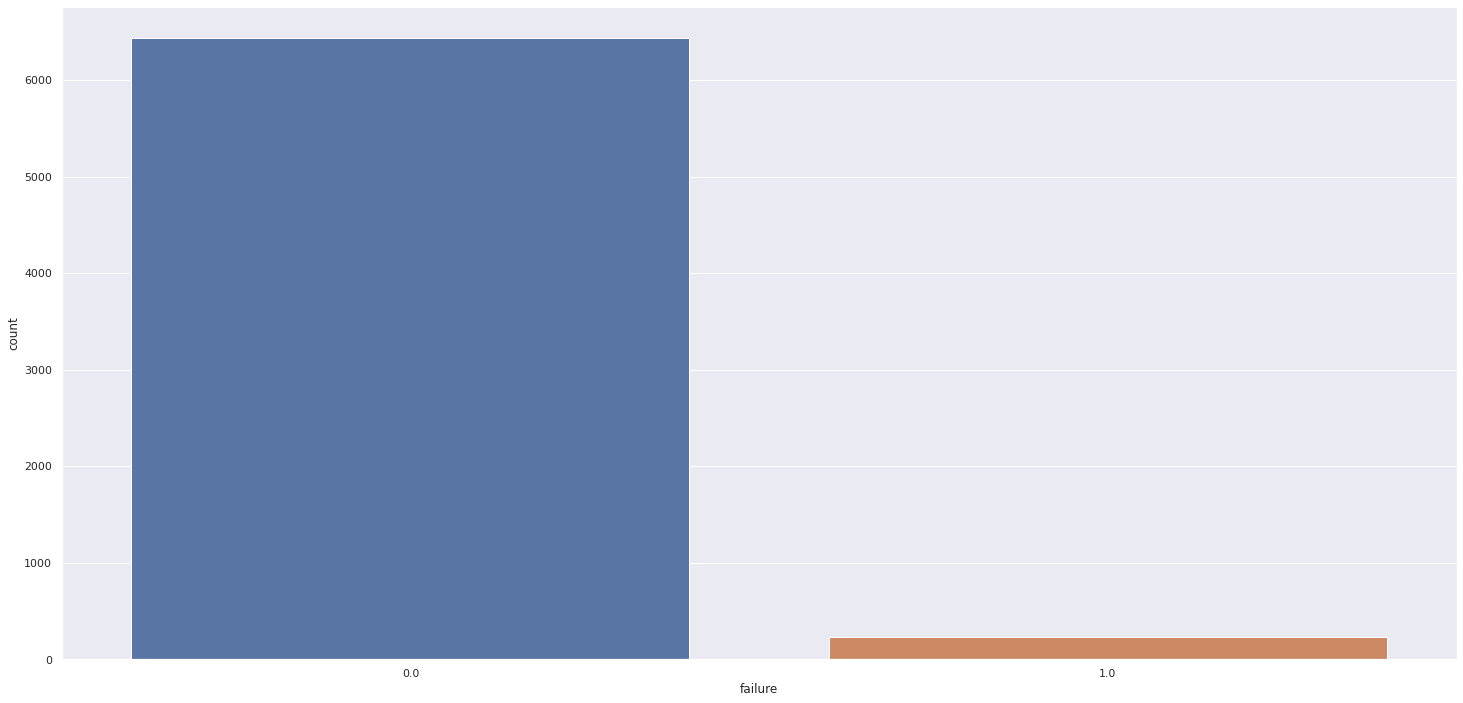

In [ ]:
#Como esperado, os dados são altamente desbalanceados.
sns.countplot( df3['failure'])


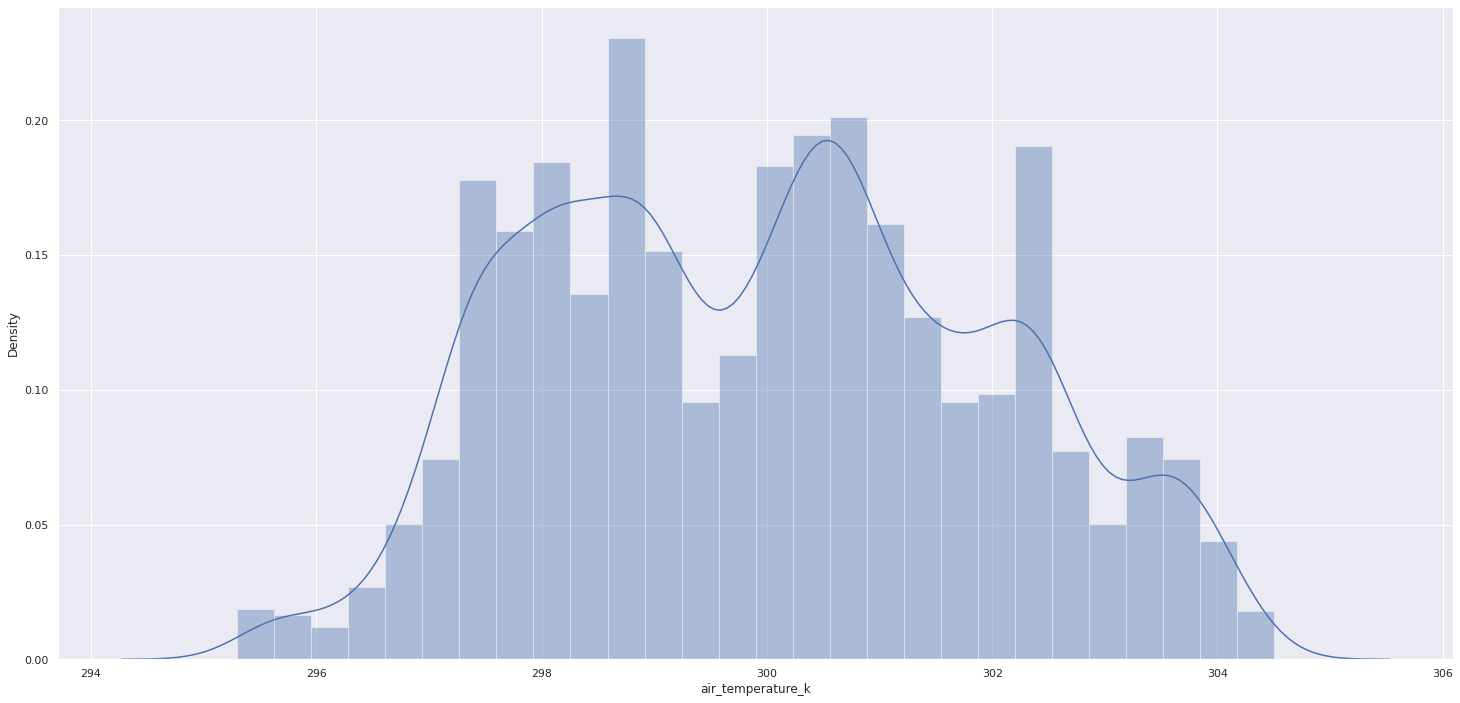

In [ ]:
sns.distplot( df3['air_temperature_k'])

#

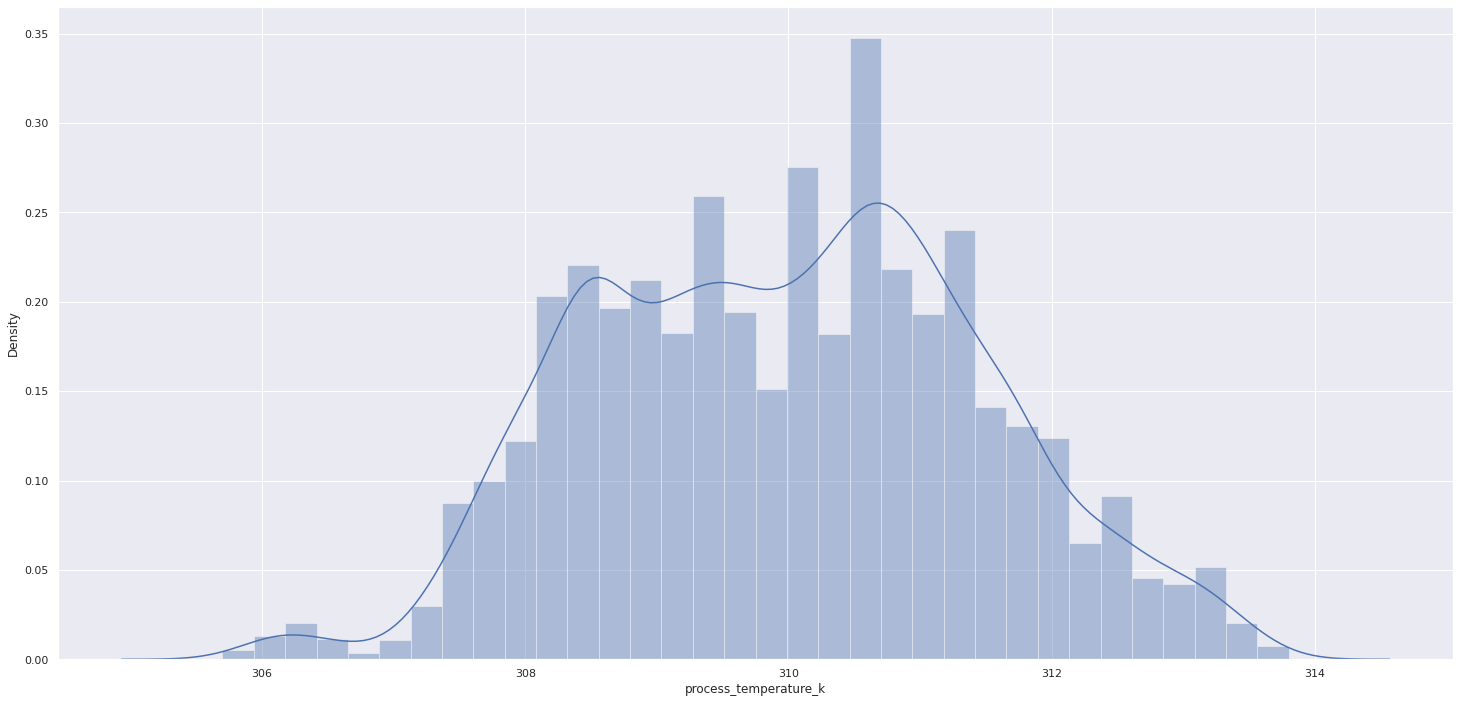

In [ ]:
sns.distplot( df3['process_temperature_k'])

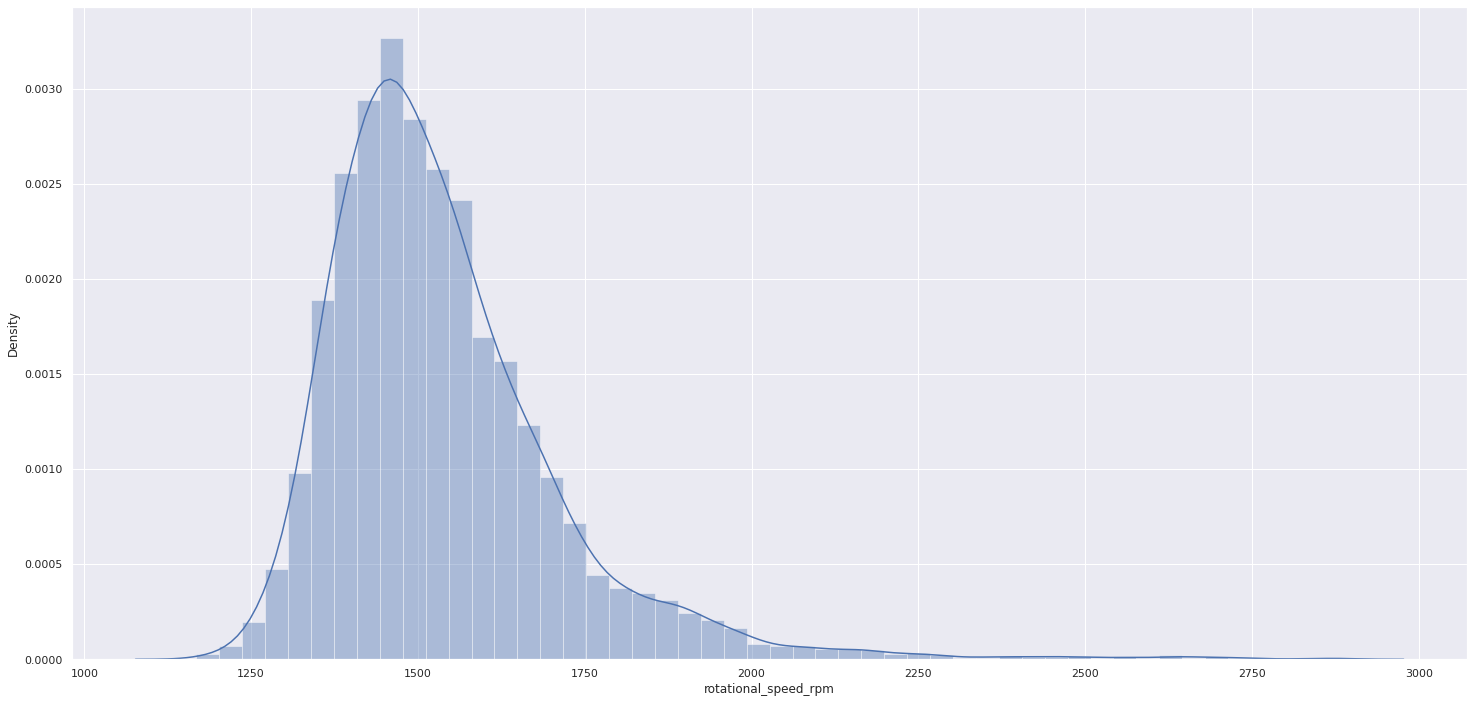

In [ ]:
sns.distplot( df3['rotational_speed_rpm'])

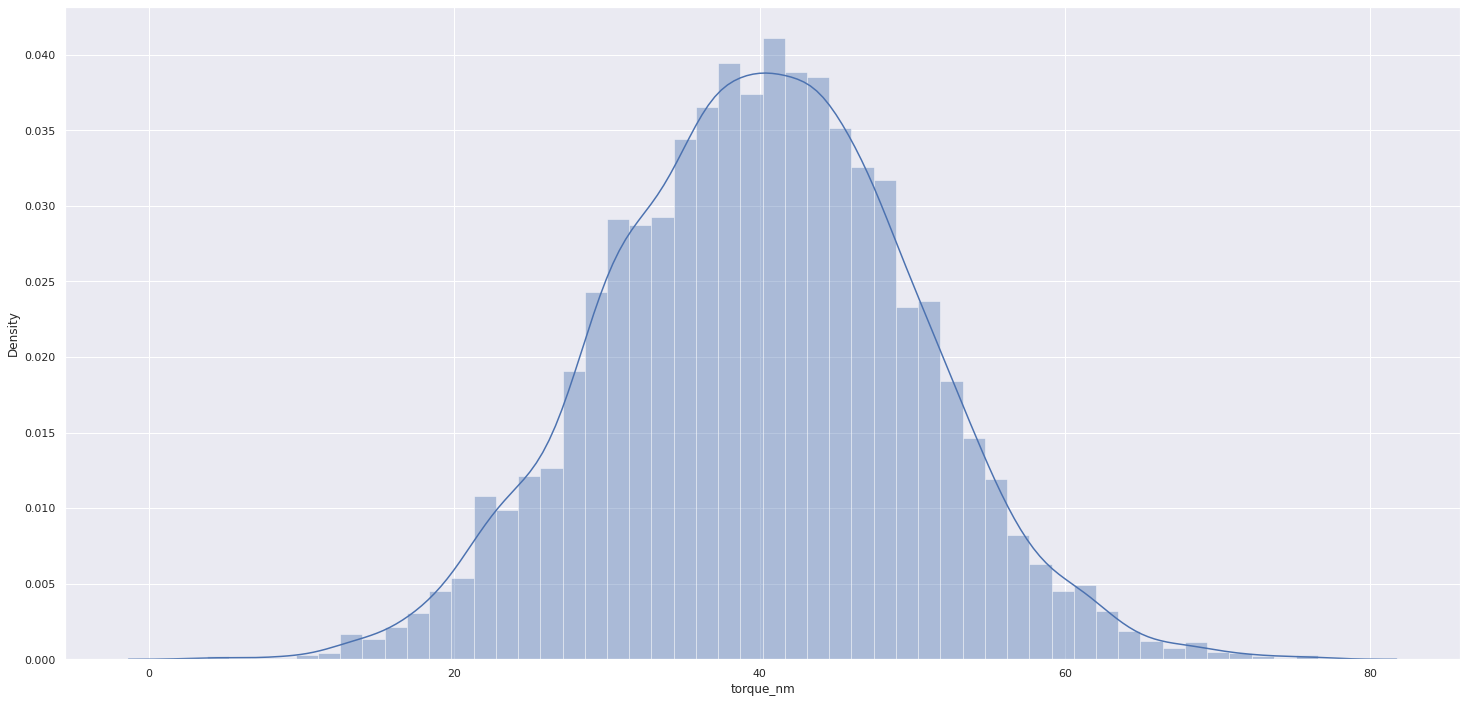

In [ ]:
sns.distplot( df3['torque_nm'])

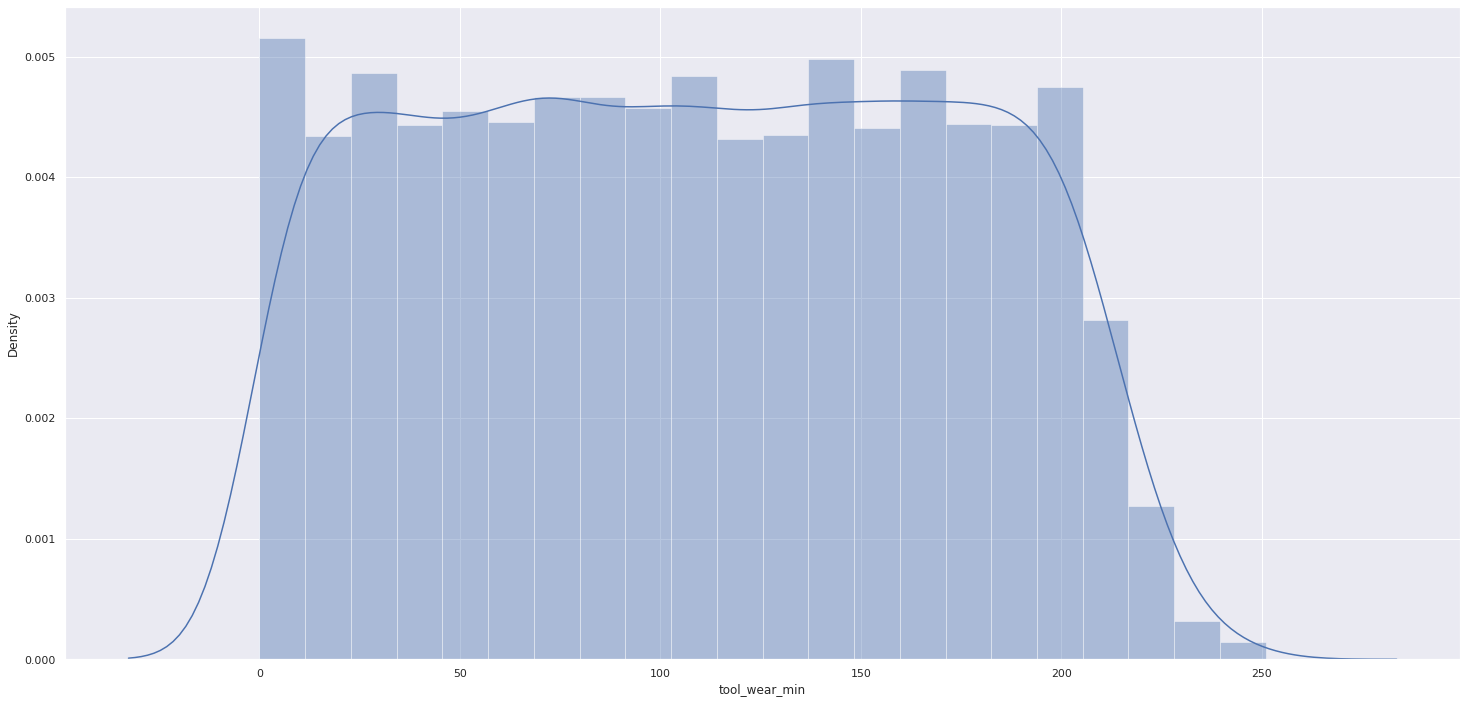

In [ ]:
sns.distplot( df3['tool_wear_min'])

In [ ]:

fig_1 = px.scatter(x=df3['tool_wear_min'], y=df3['failure_type'])
fig_1.show()

fig_2 = px.scatter(x=df3['air_temperature_k'], y=df3['failure_type'])
fig_2.show()

fig_3 = px.scatter(x=df3['process_temperature_k'], y=df3['failure_type'])
fig_3.show()

fig_4 = px.scatter(x=df3['rotational_speed_rpm'], y=df3['failure_type'])
fig_4.show()

fig_5 = px.scatter(x=df3['torque_nm'], y=df3['failure_type'])
fig_5.show()

# 5.0. PASSO 05 - DATA PREPARATION

In [ ]:
df3.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,failure,rotational_speed_rad,power_applied,PWF,TWF,heat_dissipation,overstrain,OSF
0,1,M14860,M,298.10,308.60,1551,42.80,0,No Failure,0.00,162.43,6951.81,0.00,-3.00,10.50,0.00,0.00
1,2,L47181,L,298.20,308.70,1408,46.30,3,No Failure,0.00,147.45,6826.93,0.00,1.00,10.50,138.90,0.00
2,5,L47184,L,298.20,308.70,1408,40.00,9,No Failure,0.00,147.45,5898.00,0.00,7.00,10.50,360.00,0.00
3,6,M14865,M,298.10,308.60,1425,41.90,11,No Failure,0.00,149.23,6252.75,0.00,8.00,10.50,460.90,0.00
4,7,L47186,L,298.10,308.60,1558,42.40,14,No Failure,0.00,163.16,6917.92,0.00,12.00,10.50,593.60,0.00


In [ ]:
df3.dtypes

udi                        int64
type                       int64
air_temperature_k        float64
process_temperature_k    float64
rotational_speed_rpm       int64
torque_nm                float64
tool_wear_min              int64
failure_type               int64
failure                  float64
rotational_speed_rad     float64
power_applied            float64
PWF                      float64
TWF                      float64
heat_dissipation         float64
overstrain               float64
OSF                      float64
dtype: object

## 5.3. Transformacao

In [ ]:
# failure_type - Label Encoding
le = LabelEncoder()
df3['failure_type'] = le.fit_transform( df3['failure_type'] )


# type - Ordinal Encoding
type_dict = {'L': 1,  'M': 2, 'H': 3}
df3['type'] = df3['type'].map( type_dict )

# 6.0. PASSO 06 - FEATURE SELECTION

# 6.1. Split dataframe into training and validation dataset

In [ ]:
df4 = df3.copy()

In [ ]:
y_train = df4['failure']
x_train = df4.drop('failure', axis=1)

In [ ]:
# Use the same function above for the validation set
X_train, X_val, Y_train, y_val = train_test_split(x_train, y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2

# 7.0. PASSO 07 - MACHINE LEARNING MODELLING

Este é um problema de classificação de Multiplas Classes desbalanceada.
Os algoritmos abaixo são os mais populares, e podemos usá-los:

- k-Nearest Neighbors
- Decision Trees
- Naive Bayes
- Random Forest
- Gradient Boosting

Specialized modeling algorithms may be used that pay more attention to the minority class when fitting the model on the training dataset, such as cost-sensitive machine learning algorithms.

- Cost-sensitive Logistic Regression.
- Cost-sensitive Decision Trees.
- Cost-sensitive Support Vector Machines.

Finally, alternative performance metrics may be required as reporting the classification accuracy may be misleading.

- Precision.
- Recall.
- F-Measure.

## KNN

In [ ]:
# model
knn = KNeighborsClassifier(n_neighbors=3).fit(X_train, Y_train)

#prediction
yhat_knn = knn.predict( X_val )

# performance
knn_result = ml_error( 'KNN Classifier', ( y_val ), ( yhat_knn ) )
knn_result

,Model Name,Cohen Score,F1 Score,Recall Score,MCC,Balanced Accuracy
0,KNN Classifier,0.36,0.38,0.32,0.37,0.65


## Decission Tree Classifier

Altamente afetado pelos dados desbalanceados

In [ ]:
# model
dtc = DecisionTreeClassifier().fit(X_train, Y_train)

#prediction
yhat_dtc = dtc.predict( X_val )

# performance
dtc_result = ml_error( 'Decision Tree Classifier', ( y_val ), ( yhat_dtc ) )
dtc_result

,Model Name,Cohen Score,F1 Score,Recall Score,MCC,Balanced Accuracy
0,Decision Tree Classifier,1.00,1.00,0.32,1.00,1.00


## Naive Bayes

In [ ]:
# model
gnb = GaussianNB().fit(X_train, Y_train)

#prediction
yhat_gnb = gnb.predict( X_val )

# performance
gnb_result = ml_error( 'Naive Bayes Classifier', ( y_val ), ( yhat_gnb ) )
gnb_result

,Model Name,Cohen Score,F1 Score,Recall Score,MCC,Balanced Accuracy
0,Naive Bayes Classifier,0.91,0.91,0.32,0.91,1.00


## Random Forest

In [ ]:
# model
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42).fit(X_train, Y_train)

#prediction
yhat_rfc = rfc.predict( X_val )

# performance
rfc_result = ml_error( 'Random Forest Classifier', ( y_val ), ( yhat_rfc ) )
rfc_result

,Model Name,Cohen Score,F1 Score,Recall Score,MCC,Balanced Accuracy
0,Random Forest Classifier,0.99,0.99,0.32,0.99,1.00


## Gradient Boosting

In [ ]:
# model
xgb_clf = XGBClassifier().fit(X_train, Y_train)

#prediction
yhat_xgb = xgb_clf.predict( X_val )

# performance
xgb_result = ml_error( 'Gradient Boost Classifier', ( y_val ), ( yhat_xgb ) )
xgb_result

,Model Name,Cohen Score,F1 Score,Recall Score,MCC,Balanced Accuracy
0,Gradient Boost Classifier,1.00,1.00,0.32,1.00,1.00


# 7.6. Compare Model's Performance

In [ ]:
modelling_result = pd.concat( [knn_result, dtc_result, gnb_result, rfc_result, xgb_result] )
modelling_result

,Model Name,Cohen Score,F1 Score,Recall Score,MCC,Balanced Accuracy
0,KNN Classifier,0.36,0.38,0.32,0.37,0.65
0,Decision Tree Classifier,1.00,1.00,0.32,1.00,1.00
0,Naive Bayes Classifier,0.91,0.91,0.32,0.91,1.00
0,Random Forest Classifier,0.99,0.99,0.32,0.99,1.00
0,Gradient Boost Classifier,1.00,1.00,0.32,1.00,1.00


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(y_val, yhat_xgb)

array([[1617,    0],
       [   0,   50]])

# 9.0. TRADUCAO E INTERPRETACAO DO ERRO


In [ ]:
# Classification report
print( m.classification_report(y_val, yhat_xgb) )

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1617
         1.0       1.00      1.00      1.00        50

    accuracy                           1.00      1667
   macro avg       1.00      1.00      1.00      1667
weighted avg       1.00      1.00      1.00      1667



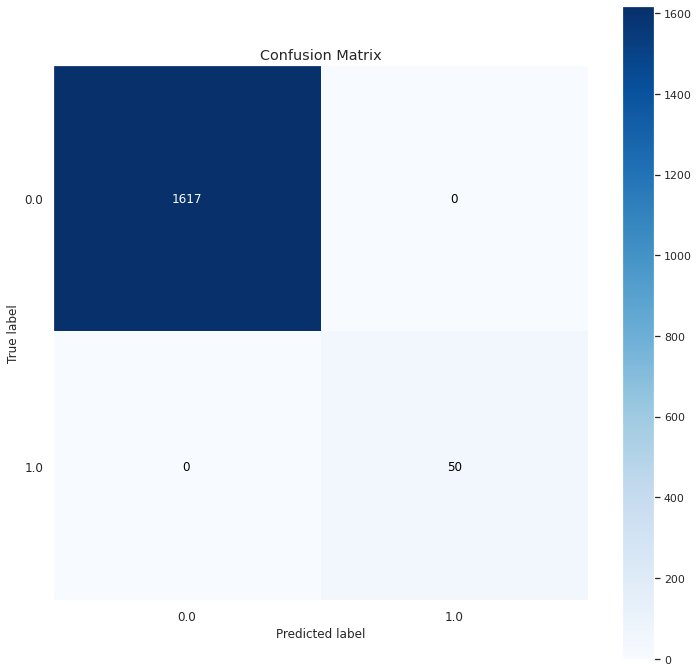

In [ ]:
# Confusion Matrix
mt.plot_confusion_matrix( y_val, yhat_xgb, normalize=False, figsize=(12,12))

In [ ]:

for i in range ( len (df2) ):
  if ((df2.loc[i, 'failure_type'] == 'No Failure')):
    df2.loc[i, 'failure'] = int( 0 )
  else:
    df2.loc[i, 'failure'] = int( 1 )

for i in range (len (df2)):
  if df2.loc[i, 'type'] == 'H':
    df2.loc[i, 'TWF'] = df2.loc[i, 'tool_wear_min'] - int(5)

  elif df2.loc[i, 'type'] == 'M':
    df2.loc[i, 'TWF'] = df2.loc[i, 'tool_wear_min'] - int(3)

  else:
    df2.loc[i, 'TWF'] = df2.loc[i, 'tool_wear_min'] - int(2)

df2['heat_dissipation'] = df2['process_temperature_k'] - df2['air_temperature_k']

# Convertendo rotational speed de rpm para rad / s
df2['rotational_speed_rad'] = df2['rotational_speed_rpm'] / 9.549
df2['power_applied'] = df2['torque_nm']*df2['rotational_speed_rad']

for i in range(len(df2)):
  if (df2.loc[i, 'power_applied'] > 9000) or (df2.loc[i, 'power_applied'] < 3500):
    df2.loc[i, 'PWF'] = 1
  else:
    df2.loc[i, 'PWF'] = 0    

df2['overstrain'] = df2['tool_wear_min'] * df2['torque_nm']

for i in range (len (df2)):
  if (df2.loc[i, 'type'] == 'H') & (df2.loc[i, 'overstrain'] > 13000):
    df2.loc[i, 'OSF'] = 1
  else:
    df2.loc[i, 'OSF'] = 0

df2 = df2.drop('product_id', axis=1)

# failure_type - Ordinal Encoding
failure_dict = {'No Failure': 0,  'Power Failure': 1, 'Tool Wear Failure': 2, 'Overstrain Failure': 3, 'Random Failures': 4, 'Heat Dissipation Failure': 5}
df3['failure_type'] = df3['failure_type'].map( failure_dict )

# type - Ordinal Encoding
type_dict = {'L': 1,  'M': 2, 'H': 3}
df3['type'] = df3['type'].map( type_dict )